In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the data
data = pd.read_csv("churn_prediction_streaming.csv")

# Prepare features and labels
X = data.drop(columns=['user_id', 'churn'])
y = data['churn']

categorical_cols = ['plan_type', 'watch_genre_pref']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Pipeline with Random Forest
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[161   0]
 [  2  37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       1.00      0.95      0.97        39

    accuracy                           0.99       200
   macro avg       0.99      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200

ROC AUC Score: 1.0


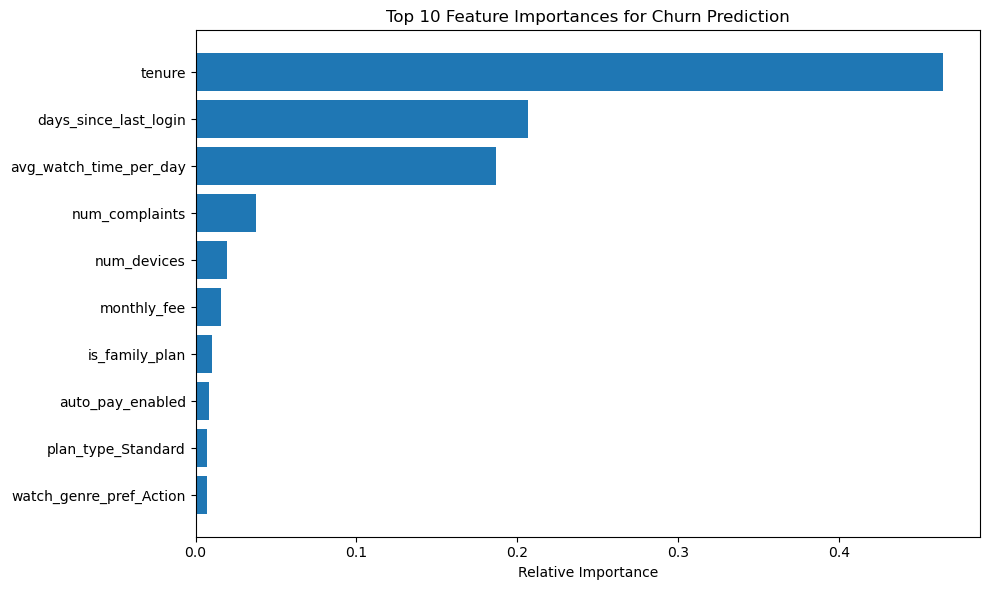

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Re-declare numeric columns manually (same ones used in training)
numeric_cols = [
    'tenure', 'monthly_fee', 'avg_watch_time_per_day',
    'days_since_last_login', 'num_devices', 'is_family_plan',
    'num_complaints', 'auto_pay_enabled'
]

# Get feature names from one-hot encoder
onehot_features = clf.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(['plan_type', 'watch_genre_pref'])
all_features = np.concatenate([onehot_features, numeric_cols])

# Get feature importances from the trained Random Forest model
importances = clf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1][:10]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances for Churn Prediction")
plt.barh(range(10), importances[indices][::-1], align="center")
plt.yticks(range(10), [all_features[i] for i in indices][::-1])
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

In [10]:
pip install xgboost shap

Note: you may need to restart the kernel to use updated packages.


In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb

# 1. Preprocess (same preprocessor used earlier)
X_encoded = preprocessor.fit_transform(X)

# 2. Split encoded data
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 3. Train XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_enc, y_train_enc)

# 4. Predict & evaluate
y_pred_xgb = xgb_model.predict(X_test_enc)
y_proba_xgb = xgb_model.predict_proba(X_test_enc)[:, 1]

print("ROC AUC:", roc_auc_score(y_test_enc, y_proba_xgb))
print(classification_report(y_test_enc, y_pred_xgb))

ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       1.00      1.00      1.00        39

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



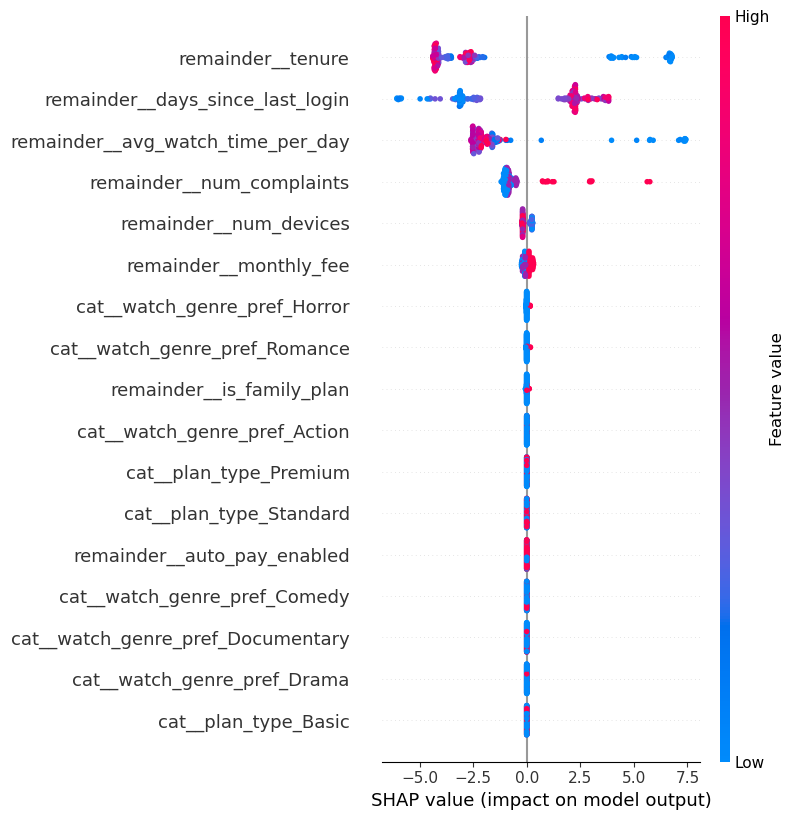

In [13]:
import shap

# Create TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# SHAP values (may take a moment)
shap_values = explainer.shap_values(X_test_enc)

# Summary plot
shap.summary_plot(shap_values, X_test_enc, feature_names=preprocessor.get_feature_names_out())

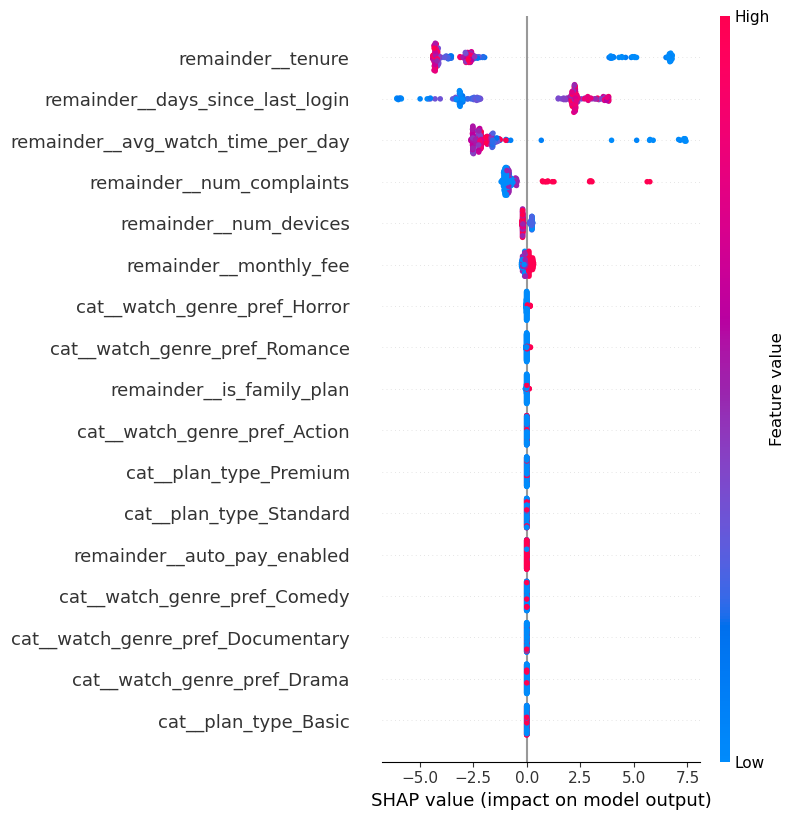

In [14]:
import shap

# 1. Create SHAP explainer from your XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# 2. Compute SHAP values on test set
shap_values = explainer.shap_values(X_test_enc)

# 3. Plot global feature importance (summary plot)
shap.summary_plot(shap_values, X_test_enc, feature_names=preprocessor.get_feature_names_out())

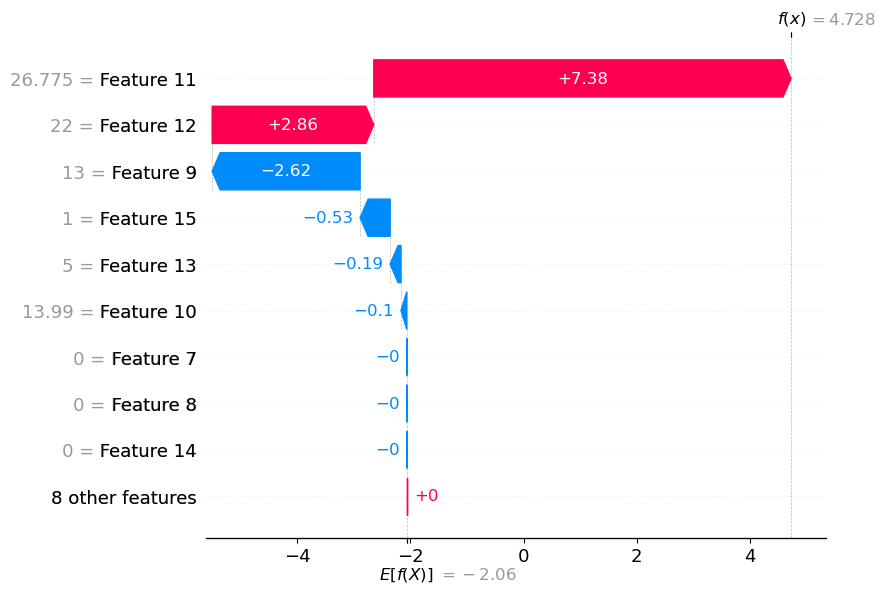

In [16]:
# Pick one test example
shap.plots.waterfall(shap_values[0], max_display=10)